In [0]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
remote: Counting objects: 6, done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0)
Unpacking objects: 100% (6/6), done.


In [0]:
!ls german-traffic-signs/

signnames.csv  test.p  train.p	valid.p


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import random
import pickle 
import pandas as pd
import cv2

Using TensorFlow backend.


In [0]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

In [0]:
np.random.seed(0)

In [0]:
with open('german-traffic-signs/train.p','rb') as f:
  train_data=pickle.load(f)
with open('german-traffic-signs/test.p','rb') as f:
  test_data=pickle.load(f)
with open('german-traffic-signs/valid.p','rb') as f:
  valid_data=pickle.load(f)

In [0]:
X_train,y_train = train_data['features'], train_data['labels']
X_test,y_test = test_data['features'], test_data['labels']
X_valid,y_valid = valid_data['features'], valid_data['labels']

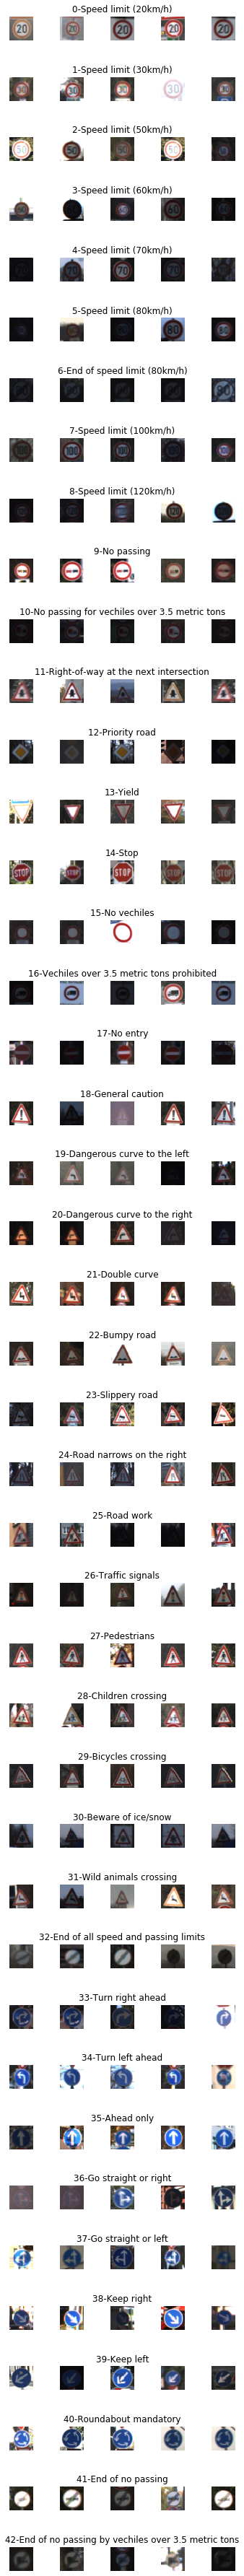

In [0]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
num_samples = []
cols = 5
num_classes = 43
fig,axs = plt.subplots(nrows=num_classes,ncols=cols,figsize=(5,50))
fig.tight_layout()
for i in range(cols):
  for j,row in data.iterrows():
    x_selected=X_train[y_train==j]
    axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected)-1)),:,:], cmap=plt.get_cmap('gray'))
    axs[j][i].axis('off')
    if i==2:
      axs[j][i].set_title(str(j) + "-" + row["SignName"])
      num_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0.5, 1.0, 'Distribution of training dataset')

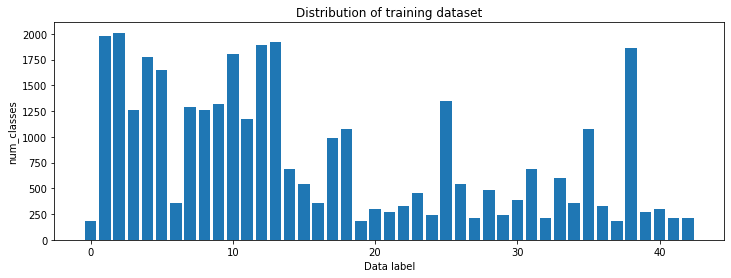

In [0]:
print(num_samples)
plt.figure(figsize=(12,4))
plt.bar(range(0,num_classes),num_samples)
plt.xlabel('Data label')
plt.ylabel('num_classes')
plt.title('Distribution of training dataset')

(32, 32, 3)
Belongs to class number 36


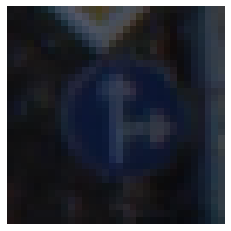

In [0]:
plt.imshow(X_train[1000])
plt.axis('off')
print(X_train[1000].shape)
print('Belongs to class number',y_train[1000])

(32, 32)


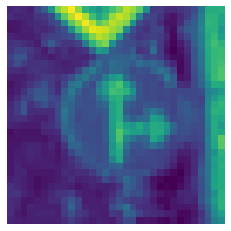

In [0]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img
img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")
print(img.shape)

In [0]:
def his_eq(img):
  img=cv2.equalizeHist(img)
  return img

In [0]:
def preprocess(img):
  img=grayscale(img)
  img=his_eq(img)
  img=img/255
  return img

In [0]:
X_train = np.array(list(map(preprocess,X_train)))
X_test  = np.array(list(map(preprocess,X_test)))
X_valid  = np.array(list(map(preprocess,X_valid)))

(34799, 32, 32)


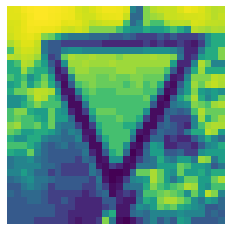

In [0]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)

In [0]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_valid = X_valid.reshape(4410, 32, 32, 1)

(15, 32, 32, 1)


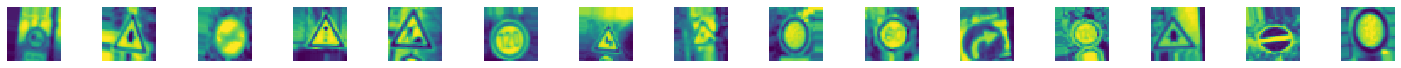

In [0]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10.)
datagen.fit(X_train)
batches = datagen.flow(X_train,y_train,batch_size=15)
X_batch,y_batch = next(batches)

fig,axs =plt.subplots(1,15,figsize=(20,5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32,32))
  axs[i].axis('off')

print(X_batch.shape)

In [0]:
y_train = to_categorical(y_train,43)
y_test = to_categorical(y_test,43)
y_valid = to_categorical(y_valid,43)

def modified_model():
  model=Sequential()
  model.add(Conv2D(60,(5,5),input_shape=(32,32,1),activation='relu')) #No of kernel matrix filters, size of kernel matrix, input image to perform conv and activation func
  model.add(Conv2D(60,(5,5),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2))) #Pooling layer to identify very prominent features only

  model.add(Conv2D(30,(3,3),activation='relu')) #No of kernel matrix filters, size of kernel matrix, input image to perform conv and activation func
  model.add(Conv2D(30,(3,3),activation='relu')) #Reduce the no of filters and their size because most of the features have already been extracted in the prev Convolution
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Flatten()) #Flattent the entire output into a single column to feed into the DNN
  model.add(Dense(500,activation='relu')) #This is to add hidden layers inside the DNN
  model.add(Dropout(0.5)) #Add dropout layer to improve performance
  model.add(Dense(43,activation='softmax')) #The outermost layer of DNN which will help classify the traffic training dataset into appropriate labels

  model.compile(Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
  return model

In [0]:
model = modified_model()
print(model.summary())

h = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50),
                            steps_per_epoch=2000,
                            epochs=10,
                            validation_data=(X_valid, y_valid), shuffle = 1)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 30)          0        

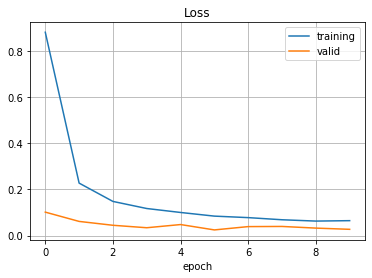

In [0]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.legend(['training','valid']) 
plt.grid('on')

Text(0.5, 0, 'epoch')

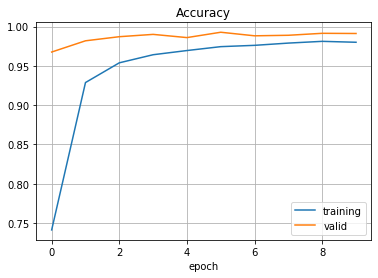

In [0]:
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.grid('on')
plt.legend(['training','valid'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [0]:
score = model.evaluate(X_test,y_test,verbose=0)
print(type(score))
print('Test score', score[0])
print('Test accuracy', score[1])

<class 'list'>
Test score 0.13069130061197526
Test accuracy 0.9685669042152351


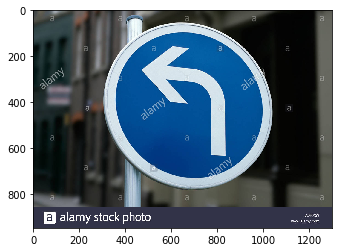

In [0]:
import requests 
from PIL import Image
url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
r= requests.get(url,stream=True)
img = Image.open(r.raw)
plt.imshow(img,cmap=plt.get_cmap('gray'))

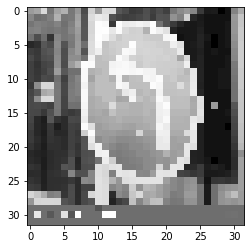

In [0]:
img = np.asarray(img)
img = cv2.resize(img,(32,32))
img = preprocess(img)
plt.imshow(img,cmap=plt.get_cmap('gray'))
img = img.reshape(1,32,32,1)

In [0]:

prediction = model.predict_classes(img)
print('Predicted image belongs to data label: ', str(prediction))

Predicted image belongs to data label:  [5]
